In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import os


In [2]:
os.listdir(".")

['Naive Bayes sentiment analysis.ipynb',
 'my_screenshot.png',
 'Table_8_Offenses_Known_to_Law_Enforcement_by_State_by_City_2013.xls',
 'credit',
 'NY_city_offense_2013.ipynb',
 'Visualisation churn.ipynb',
 '.DS_Store',
 'Airbnb.ipynb',
 'LICENSE',
 'plane_crashes_data.csv',
 'rezscore',
 'Unit 3 - Lesson 3 - Chapter 4.ipynb',
 'Untitled.ipynb',
 'Iris.ipynb',
 'KaggleV2-May-2016.csv',
 'DRILL - Exploring the Central Limit Theorem.ipynb',
 'food_data',
 'kernel_final.ipynb',
 'first_linear.ipynb',
 'my_screenshot_0.png',
 'WELLCOME_APCspend2013_forThinkful.csv',
 'my_screenshot_1.png',
 'README.md',
 'forest_cover-PCA.ipynb',
 'forest_cover.ipynb',
 '.gitignore',
 'forest_cover.csv',
 '.env',
 'kernel_final-Copy1.ipynb',
 'Airplace crash.ipynb',
 'NY_city_offense_2013-Copy1.ipynb',
 'winemag-data-130k-v2.csv',
 '.ipynb_checkpoints',
 '.git',
 'sentiment',
 'Data cleaning.ipynb',
 'no_show_rate.ipynb',
 'WA_Fn-UseC_-Telco-Customer-Churn.csv',
 'pm_hack',
 'OneDrive_1_05-10-2018',
 'tab

In [3]:
review_raw = pd.read_csv("sentiment/imdb_labelled.txt", delimiter= '\t', header=None)
review_raw.columns = ['review', 'classif']
second_raw = pd.read_csv("sentiment/yelp_labelled.txt", delimiter= '\t', header=None)
second_raw.columns = ['review', 'classif']

# Data

There are 748 reviews.
We have 2 types of classification : 0 or 1.

In [4]:
review_raw.classif.unique()

array([0, 1])

In [5]:
review_raw.shape

(748, 2)

In [6]:
review_raw[review_raw.classif==0].sample(10)

,review,classif
702,It's too bad that everyone else involved didn'...,0
746,Exceptionally bad!,0
436,He really didn't seem to want to be hosting; h...,0
321,Final Word: This Show is a real torture!!,0
307,About ten minutes into this film I started hav...,0
341,i wouldnt see this movie again for free.,0
279,The directing is sloppy at best.,0
744,"Unfortunately, any virtue in this film's produ...",0
114,Everything is appalling.,0
317,Everything about it is just bad.,0


In [7]:
review_raw[review_raw.classif==1].sample(10)

,review,classif
733,Still it's quite interesting and entertaining ...,1
294,But this movie really got to me.,1
157,I must say I have taped most of the episodes a...,1
700,It presents a idyllic yet serious portrayal of...,1
415,Go watch it!,1
287,"This movie was kind of long in length, but I e...",1
142,So for our enjoyment we get to see them run ar...,1
665,"Hopefully, the director James Cox can turn the...",1
468,"If you do watch it, however, there are small c...",1
689,"People who like European films and ""art movies...",1


# Brut force!

Let see at the word that are used in one type fo review and not the other....

In [8]:
import re

In [9]:
words_bad = set()
regex_pat = re.compile(r"\W", flags=re.IGNORECASE)
for i in review_raw[(review_raw.classif==0)].review.str.replace(regex_pat," ",regex=True):
    words_bad = words_bad.union(set(i.lower().split(" ")))
words_good = set()
for i in review_raw[(review_raw.classif==1)].review.str.replace(regex_pat," ",regex=True):
    words_good = words_good.union(set(i.lower().split(" ")))
    
keywords= set(str(k) for k in words_good.union(words_bad) - words_bad.intersection(words_good))

In [10]:
len(keywords)

2298

In [11]:
for key in keywords:
    regex_pat = re.compile(r"\W"+str(key) + '\W', flags=re.IGNORECASE)
    review_raw[str(key)] = review_raw.review.str.contains(
        regex_pat
    )
    second_raw[str(key)] = second_raw.review.str.contains(
        regex_pat
    )

In [142]:
review_raw["question"] = review_raw.review.str.contains("\?")
review_raw["love"] = review_raw.review.str.contains("love*")



In [143]:
review_raw["the_length"] = review_raw.review.str.len()

In [144]:
review_raw["the_length_class"]=pd.cut(review_raw.the_length,[0,50,150,200,max(review_raw.the_length)])

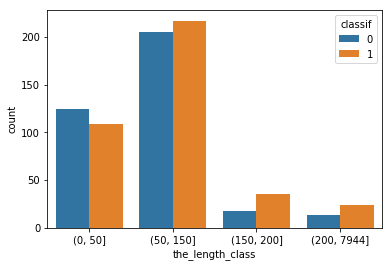

In [145]:
sns.countplot(data=review_raw,x="the_length_class",hue="classif")


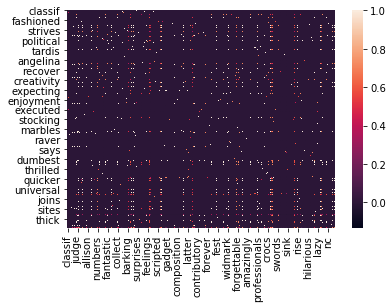

In [96]:
sns.heatmap(review_raw.corr())

In [12]:
data = review_raw[list(keywords)]
target = review_raw.classif

In [13]:
# Our data is binary / boolean, so we're importing the Bernoulli classifier.
from sklearn.naive_bayes import BernoulliNB

# Instantiate our model and store it in a new variable.
bnb = BernoulliNB()

# Fit our model to the data.
bnb.fit(data, target)

# Classify, storing the result in a new variable.
y_pred = bnb.predict(data)

# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    data.shape[0],
    (target != y_pred).sum()
))
review_raw["result"] = True
review_raw.loc[(target != y_pred),"result"] = False

Number of mislabeled points out of a total 748 points : 62


In [14]:
review_raw.shape

(748, 2301)

# Results

The result seems to be very impressive, only 60 mystakes... but is it real?

In [15]:
pd.crosstab(review_raw.classif,review_raw.result)

result,False,True
classif,,
0,62,300
1,0,386


In [16]:
from sklearn.model_selection import cross_val_score
cross_val_score(bnb, data, target, cv=10)

array([0.84210526, 0.82894737, 0.65333333, 0.78666667, 0.77333333,
       0.78666667, 0.82432432, 0.83783784, 0.67567568, 0.74324324])

# Hypothesis

As we are using every single words in that is in one kind of review and not the other, we might be doing our classification of word that are only use in a limited number of reviews.

If our hypothesis is right, we should get less variation by removing the words that are only used in a few reviews.

Doing a histrogramme of the number of occurence, we notice we have a majority of keyword that only occures once or twice: those are good candidate for "overfitting".

(array([1.914e+03, 2.680e+02, 7.400e+01, 2.800e+01, 7.000e+00, 4.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 2.000e+00]),
 array([ 0. ,  1.2,  2.4,  3.6,  4.8,  6. ,  7.2,  8.4,  9.6, 10.8, 12. ]),
 <a list of 10 Patch objects>)

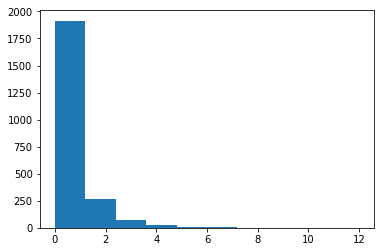

In [17]:
numbers_of_occurence = []
for key in keywords:
    numbers_of_occurence.append(np.sum(review_raw[key]))
    if np.sum(review_raw[key])> 748:
        print(key,np.sum(review_raw[key]))
plt.hist(numbers_of_occurence)


# Cleaning up

Let's remove the occurence that only appear a limited number of time, let's say less than 3 times..

12


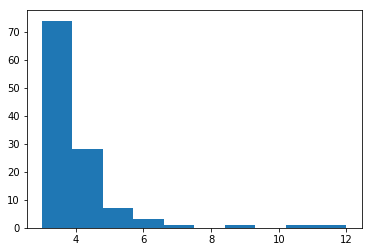

In [18]:
keywords_2 = []
numbers_of_occurence = []

for key in keywords:
    if np.sum(review_raw[key])> 2:
        keywords_2.append(key)
        numbers_of_occurence.append(np.sum(review_raw[key]))
plt.hist(numbers_of_occurence)
print(max(numbers_of_occurence))

In [19]:
data_less = review_raw[list(keywords_2)]
target = review_raw.classif
# Fit our model to the data.
bnb.fit(data_less, target)

# Classify, storing the result in a new variable.
y_pred = bnb.predict(data_less)

# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    data_less.shape[0],
    (target != y_pred).sum()
))
review_raw["result"] = True
review_raw.loc[(target != y_pred),"result"] = False
print(cross_val_score(bnb, data_less, target, cv=10))

Number of mislabeled points out of a total 748 points : 228
[0.69736842 0.67105263 0.72       0.72       0.64       0.68
 0.71621622 0.71621622 0.66216216 0.7027027 ]


In [20]:
data_2 = second_raw[list(keywords_2)]
target_2 = second_raw.classif

In [22]:
y_pred_2 = bnb.predict(data_2)

# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    data_2.shape[0],
    (target_2 != y_pred_2).sum()
))
second_raw["result"] = True
second_raw.loc[(target_2 != y_pred_2),"result"] = False
pd.crosstab(second_raw.classif,second_raw.result)

Number of mislabeled points out of a total 1000 points : 450


result,False,True
classif,,
0,387,113
1,63,437


In [24]:
keywords_2

['writer',
 'wouldn',
 'etc',
 'cheap',
 'occasionally',
 'involved',
 'picture',
 'tale',
 'possible',
 'set',
 'shots',
 'looking',
 'couldn',
 'joy',
 'exactly',
 'place',
 'entertaining',
 'fantastic',
 'recent',
 'ed',
 'silent',
 'wind',
 'enjoyable',
 'feel',
 'effective',
 'south',
 'storyline',
 'giallo',
 'wilkinson',
 'imagination',
 'trash',
 'unconvincing',
 'remake',
 'ridiculous',
 'role',
 'brilliant',
 'actresses',
 'awful',
 'worst',
 'beginning',
 'intelligence',
 'roles',
 'miyazaki',
 'adorable',
 'lion',
 'although',
 'embarrassing',
 'checking',
 'space',
 'mediocre',
 'true',
 'superb',
 'hilarious',
 'become',
 'free',
 'sure',
 'sea',
 'touching',
 'pathetic',
 'average',
 'faux',
 'score',
 'bore',
 'learn',
 'money',
 'due',
 'rating',
 'gem',
 'photography',
 'appreciate',
 'nonsense',
 'paced',
 'directed',
 'genuine',
 'along',
 'interesting',
 'rate',
 'heart',
 'annoying',
 'mean',
 'appearance',
 'wasted',
 'provoking',
 'example',
 'charming',
 'clich

We are basically over-fitting the Imdb reviews, but an only get 60% of the labelling correct for Yelp: this is not very good...

# A more subtle way ?

Let see if we can do better by selecting keywords that will make more sense.. and some feather engineering.

In [25]:
review_raw = pd.read_csv("sentiment/imdb_labelled.txt", delimiter= '\t', header=None)
review_raw.columns = ['review', 'classif']
second_raw = pd.read_csv("sentiment/yelp_labelled.txt", delimiter= '\t', header=None)
second_raw.columns = ['review', 'classif']

In [26]:
keywords = ['awful', 'bad', 'worst', 'barely','predictable','boring', 'irritating', 'good', 'wonderful',"trash","pointless","waste","but"
           ,'disappointing',"cheap","poor",'DO NOT RENT','aimless','nonetheless','horrendous',"avoid","terrible","shameful","best"]


In [27]:
for key in keywords:
    regex_pat = re.compile(r"\W"+str(key) + '\W', flags=re.IGNORECASE)
    review_raw[str(key)] = review_raw.review.str.contains(
        regex_pat
    )
    second_raw[str(key)] = second_raw.review.str.contains(
        regex_pat
    )

55


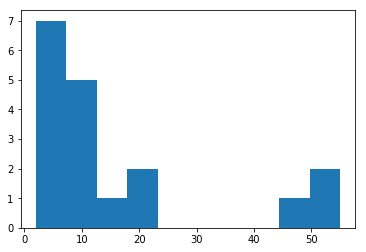

In [28]:
keywords_2 = []
numbers_of_occurence = []

for key in keywords:
    if np.sum(review_raw[key])> 1:
        keywords_2.append(key)
        numbers_of_occurence.append(np.sum(review_raw[key]))
plt.hist(numbers_of_occurence)
print(max(numbers_of_occurence))

By looking at the reviews, it seems that negative reviews often finish with a question mark, let's see if this is indeed true:

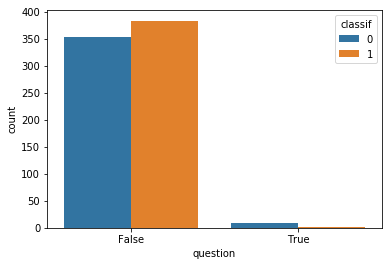

In [29]:
review_raw["question"] = review_raw.review.str.contains("\?")
review_raw["love"] = review_raw.review.str.contains("love*")

second_raw["question"] = second_raw.review.str.contains("\?")
second_raw["love"] = second_raw.review.str.contains("love*")

sns.countplot(data=review_raw,x="question",hue="classif")



Indeed it seems that review with a question mark are more likely to be negative, and positive when they do not have one.

# Review length : can it help?

Assumtion here is that when you like a film, you are more likely to give a longer review...

We can test this hypothesis.

In [33]:
review_raw["length"] = review_raw.review.str.len()
second_raw["length"] = second_raw.review.str.len()


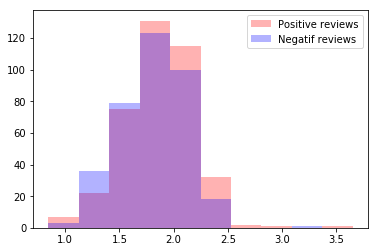

In [34]:
_,bins,_  = plt.hist(np.log10(review_raw[review_raw.classif==1].length),bins=10,color="red",label="Positive reviews",alpha=0.3)
plt.hist(np.log10(review_raw[review_raw.classif==0].length),bins=bins,color="blue",label="Negatif reviews",alpha=0.3)
plt.legend()

Here again the difference seems to be subtle, but there is still one, so we can see if it helps with the classification by binning the length variable.

In [35]:
review_raw["length_class"]= review_raw.length>60
second_raw["length_class"]= second_raw.length>60

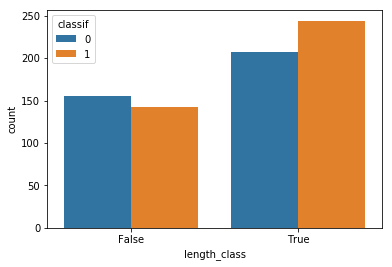

In [36]:
sns.countplot(data=review_raw,x="length_class",hue="classif")


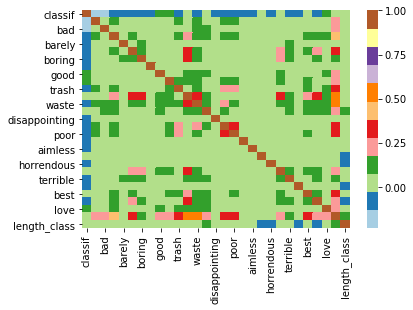

In [37]:
sns.heatmap(review_raw.corr(),cmap=plt.get_cmap("Paired"))

In [38]:
data = review_raw[list(keywords)+["question","length_class","love"]]
target = review_raw.classif

In [39]:
# Our data is binary / boolean, so we're importing the Bernoulli classifier.
from sklearn.naive_bayes import BernoulliNB

# Instantiate our model and store it in a new variable.
bnb = BernoulliNB()

# Fit our model to the data.
bnb.fit(data, target)

# Classify, storing the result in a new variable.
y_pred = bnb.predict(data)

# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    data.shape[0],
    (target != y_pred).sum()
))
review_raw["result"] = True
review_raw.loc[(target != y_pred),"result"] = False

Number of mislabeled points out of a total 748 points : 251


In [40]:
print(cross_val_score(bnb, data_less, target, cv=10))

[0.69736842 0.67105263 0.72       0.72       0.64       0.68
 0.71621622 0.71621622 0.66216216 0.7027027 ]


In [41]:
pd.crosstab(review_raw.classif,review_raw.result)

result,False,True
classif,,
0,242,120
1,9,377


In [42]:
bnb.coef_



array([[-5.96100534, -4.16924587, -5.96100534, -5.26785816, -4.86239305,
        -4.57471098, -5.96100534, -2.52701814, -3.07063358, -5.96100534,
        -5.26785816, -5.26785816, -2.59370951, -5.96100534, -5.96100534,
        -5.96100534, -5.96100534, -5.96100534, -5.26785816, -5.96100534,
        -5.26785816, -4.86239305, -5.96100534, -3.25295514, -4.86239305,
        -0.45974713, -2.82551112]])

In [43]:
# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(bnb)
shap_values = explainer.shap_values(x)

# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

NameError: name 'shap' is not defined

In [44]:
data_2 = second_raw[list(keywords)+["question","length_class","love"]]
target_2 = second_raw.classif

In [45]:
y_pred_2 = bnb.predict(data_2)

# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    data_2.shape[0],
    (target_2 != y_pred_2).sum()
))
second_raw["result"] = True
second_raw.loc[(target_2 != y_pred_2),"result"] = False
pd.crosstab(second_raw.classif,second_raw.result)

Number of mislabeled points out of a total 1000 points : 439


result,False,True
classif,,
0,439,61
1,0,500


It the second attemps, we get a much lower classification rate on Imbd, but almost the same rate for yelp.

Looking at the IMDB review, it seems that a lot of the reviews are "sarcasstic", meaning that they are more difficult to find using a simple Naive Bayes model.
